<a href="https://colab.research.google.com/github/aniruddha-ui/machine-learning/blob/main/tut7/tut7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(7, 7) (1, 7)
(7, 7) (1, 7)
Alphas for hard margins:  [[5.47617734e-11]
 [5.34108215e-11]
 [6.43637613e-11]
 [4.73337833e-11]
 [8.10396239e-10]
 [5.98183343e-11]
 [6.57989653e-11]
 [1.83731761e-10]
 [3.73366391e-11]
 [9.28928086e+01]
 [1.39847117e-10]
 [4.52859858e-11]
 [9.26646742e+02]
 [8.99819676e-10]
 [4.88025197e-11]
 [1.35729106e-10]
 [1.42021855e-09]
 [7.45676303e-11]
 [4.68578362e-10]
 [2.81133456e-09]
 [4.64883344e-11]
 [9.07807359e-11]
 [1.36675184e-09]
 [2.93905073e-11]
 [7.76061720e-10]
 [8.93448786e-11]
 [2.57428858e-09]
 [5.48086203e-11]
 [4.98162401e-11]
 [6.85425068e-11]
 [4.24951279e-11]
 [5.00331106e-11]
 [7.49978082e-10]
 [4.70458444e-11]
 [4.88549691e-10]
 [6.57407875e-11]
 [9.36330609e-11]
 [4.51391583e-11]
 [5.46027642e-10]
 [1.85961018e-10]
 [5.71576911e-11]
 [1.08616026e-10]
 [3.56329223e-10]
 [1.53917663e-10]
 [1.13526585e-10]
 [4.18904296e-11]
 [5.70610849e-11]
 [1.31267504e-10]
 [2.28372518e-10]
 [6.29588409e-11]
 [1.27209635e-10]
 [3.67070255e-10]
 [5.370672

In [2]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[2.17890962e-11]
 [2.25557467e-11]
 [2.51330179e-11]
 [1.94006988e-11]
 [3.81416223e-10]
 [2.43293641e-11]
 [2.12912932e-11]
 [7.39054805e-11]
 [1.55940619e-11]
 [9.28928086e+01]
 [5.73266569e-11]
 [1.73519783e-11]
 [9.26646742e+02]
 [4.27029667e-10]
 [1.99244880e-11]
 [5.72939342e-11]
 [6.87144372e-10]
 [2.47858847e-11]
 [2.04102065e-10]
 [1.43463423e-09]
 [1.76676164e-11]
 [3.91582294e-11]
 [6.34836752e-10]
 [1.23873783e-11]
 [3.64436511e-10]
 [3.85252045e-11]
 [1.32652434e-09]
 [2.06485500e-11]
 [1.94444729e-11]
 [2.86055685e-11]
 [1.65765409e-11]
 [2.09577379e-11]
 [2.92958425e-10]
 [1.84875078e-11]
 [2.20084820e-10]
 [2.65649008e-11]
 [3.59801022e-11]
 [1.90616621e-11]
 [1.21077141e-09]
 [7.28562530e-11]
 [2.32261531e-11]
 [4.27097919e-11]
 [1.57429415e-10]
 [5.71350521e-11]
 [4.36777172e-11]
 [1.72876947e-11]
 [1.97657398e-11]
 [5.37783768e-11]
 [9.36378034e-11]
 [2.57591862e-11]
 [4.82070341e-11]
 [1.59348233e-10]
 [2.18702036e-11]
 [3.66173608e-11]
 [

<a list of 5 text.Text objects>

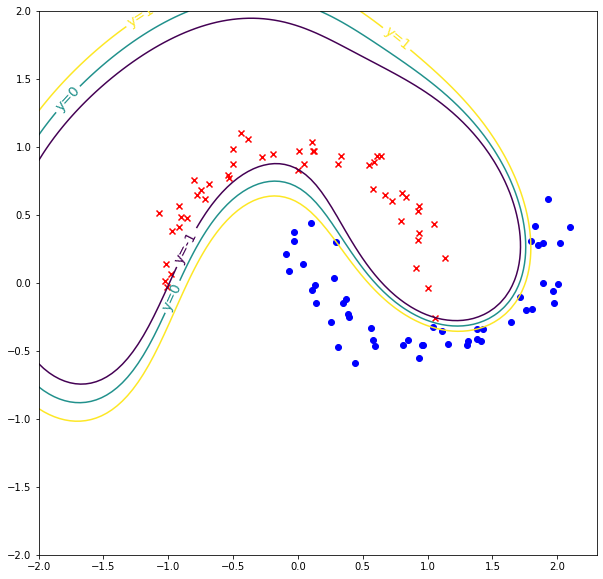

In [3]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=14)

<a list of 5 text.Text objects>

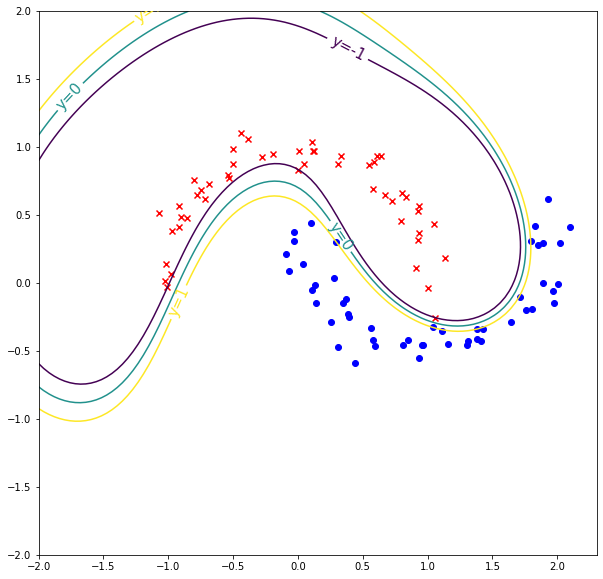

In [4]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)